# Mood Prediction Using Smartphone Data
### Data Mining Techniques | Vrije Universiteit Amsterdam | April 2024
##### Lieve Jilesen (ljn278), Ryan Ott (rot280), and Jaime Perez y Perez (jpz240) | Group 17

## 1 - Data Preparation

### 1.1 - Exploratory Data Analysis

#### Importing packages & loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# sns.set(style="whitegrid")
# import statsmodels.api as sm

file_path = 'data/dataset_mood_smartphone.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col=0)
df

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


#### General data properties

In [2]:
num_records = df.shape[0]
num_participants = df.id.nunique()
num_days = df.time.dt.date.nunique()
num_variables = df.variable.nunique()

data_characteristics = {
    "Number of Records": [num_records],
    "Number of Participants": [num_participants],
    "Number of Days": [num_days],
    "Number of Variables": [num_variables],
}

data_characteristics_df = pd.DataFrame(data_characteristics)
data_characteristics_df

,Number of Records,Number of Participants,Number of Days,Number of Variables
0,376912,27,113,19


#### Variable properties

In [3]:
# Create a summary table for the dataset
summary_data = {
    "Variable": [],
    "Data Type": [],
    "Total Records": [],
    "Unique Values": [],
    "Missing Values": [],
    "Mean": [],
    "Std": [],
    "Min": [],
    "25%": [],
    "50%": [],
    "75%": [],
    "Max": []
}

for var in df.variable.unique():
    var_data = df[df['variable'] == var]['value']
    desc = var_data.describe()
    summary_data["Variable"].append(var)
    summary_data["Data Type"].append(df[df['variable'] == var]['value'].dtype)
    summary_data["Total Records"].append(var_data.count())
    summary_data["Unique Values"].append(var_data.nunique())
    summary_data["Missing Values"].append(df[df['variable'] == var]['value'].isnull().sum())
    summary_data["Mean"].append(desc['mean'])
    summary_data["Std"].append(desc['std'])
    summary_data["Min"].append(desc['min'])
    summary_data["25%"].append(desc['25%'])
    summary_data["50%"].append(desc['50%'])
    summary_data["75%"].append(desc['75%'])
    summary_data["Max"].append(desc['max'])

summary_table = pd.DataFrame(summary_data)
summary_table


,Variable,Data Type,Total Records,Unique Values,Missing Values,Mean,Std,Min,25%,50%,75%,Max
0,mood,float64,5641,10,0,6.992555,1.032769,1.000,7.00000,7.000000,8.000000,10.000
1,circumplex.arousal,float64,5597,5,46,-0.098624,1.051868,-2.000,-1.00000,0.000000,1.000000,2.000
2,circumplex.valence,float64,5487,5,156,0.687808,0.671298,-2.000,0.00000,1.000000,1.000000,2.000
3,activity,float64,22965,1868,0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
4,screen,float64,96578,64646,0,75.335206,253.822497,0.035,5.32225,20.044500,62.540250,9867.007
5,call,float64,5239,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
6,sms,float64,1798,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
7,appCat.builtin,float64,91288,23237,0,18.538262,415.989243,-82798.871,2.02000,4.038000,9.922000,33960.246
8,appCat.communication,float64,74276,39890,0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777
9,appCat.entertainment,float64,27125,12575,0,37.576480,262.960476,-0.011,1.33400,3.391000,14.922000,32148.677


#### Any records missing id or time?

In [4]:
# Do we have any records without index, id or time?
df[df['id'].isnull() | df['time'].isnull()]

,id,time,variable,value


No, thankfully not.

#### Distribution of variable values

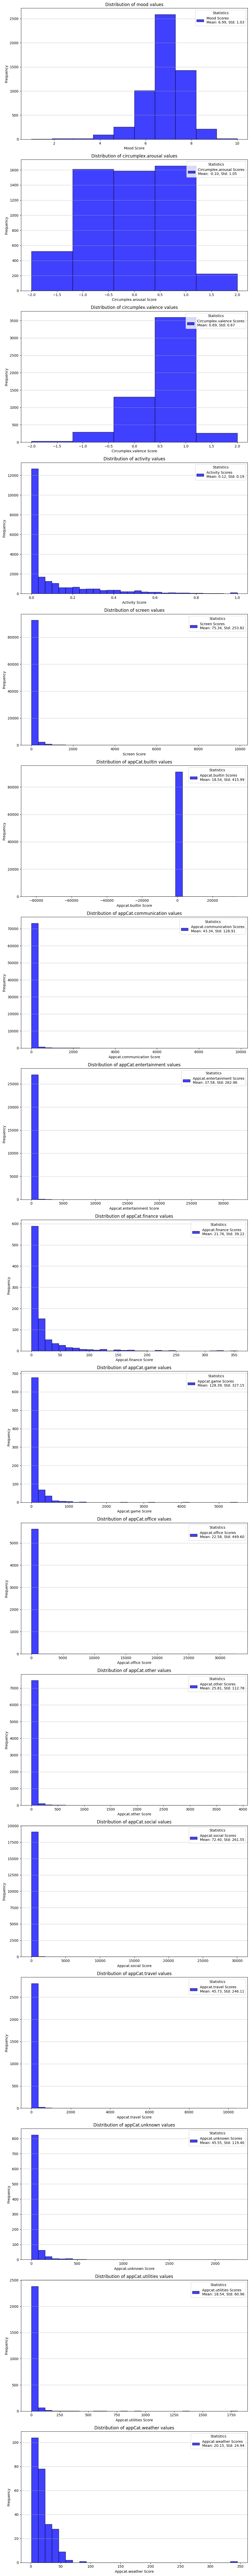

In [5]:
variables = [var for var in df['variable'].unique() if var not in ['sms', 'call']]
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 6 * len(variables)))

for ax, var in zip(axes.flatten(), variables):
    var_data = df[df['variable'] == var]['value'].dropna()
    mean = var_data.mean()
    std = var_data.std()
    # Adjust bins for better visualization based on data range and characteristics
    bins = min(30, int(var_data.nunique()))  # Use a minimum of 30 bins or less if fewer unique values

    ax.hist(var_data, bins=bins, alpha=0.75, color='blue', edgecolor='black', label=f'{var} Scores')
    ax.set_title(f'Distribution of {var} values')
    ax.set_xlabel(f'{var.capitalize()} Score')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.75)
    legend_label = f"Mean: {mean:.2f}, Std: {std:.2f}"
    ax.legend([f"{var.capitalize()} Scores\n{legend_label}"], loc='upper right', title='Statistics', frameon=True)

plt.tight_layout()
plt.show()

Histogram showing the distribution of possible mood scores in our dataset. The mood of participants seems to be normally distributed with a mean and standard deviation of around 7 and 1 respectively.

#### Mood for a participant

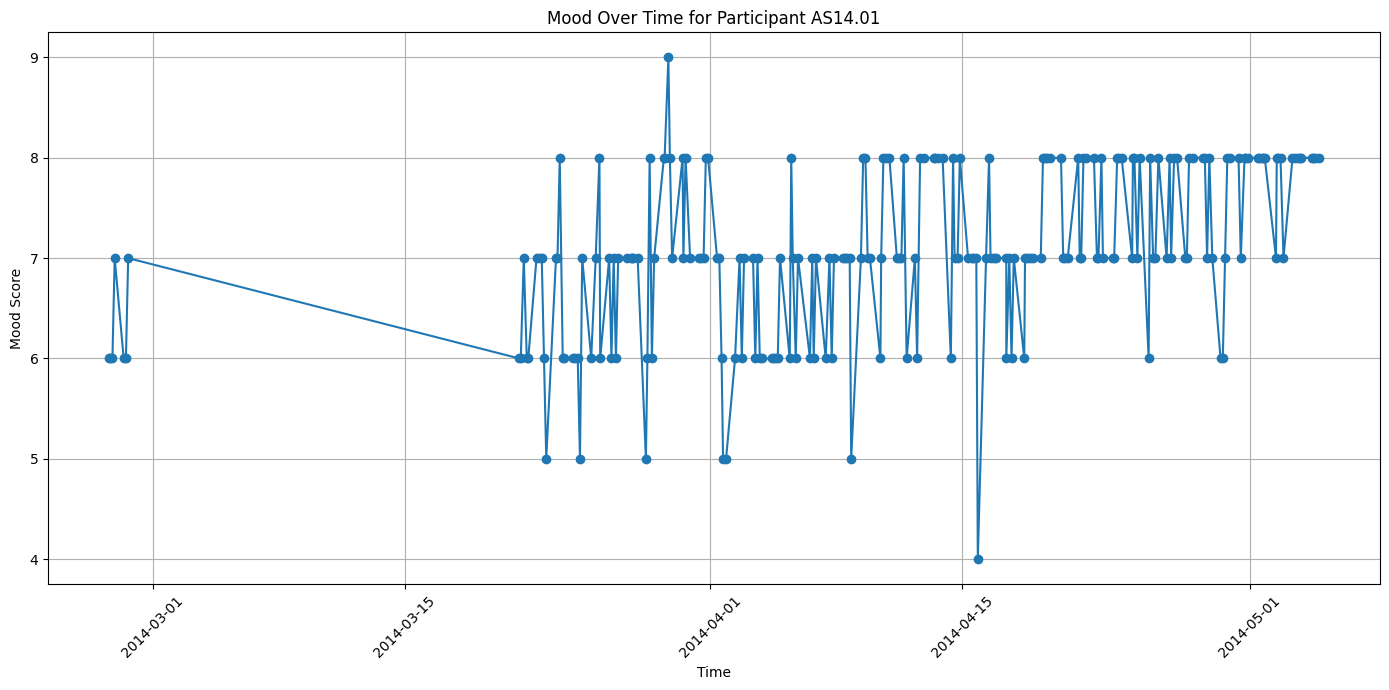

In [6]:
# Time Series of Mood for a Selected Participant
participant_data = df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')]
plt.figure(figsize=(14, 7))
plt.plot(participant_data['time'], participant_data['value'], marker='o', linestyle='-')
plt.title('Mood Over Time for Participant AS14.01')
plt.xlabel('Time')
plt.ylabel('Mood Score')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Timeseries plot of the mood scores given by the first participant. We see it being around 7 +- 1 for most of the time, with rare moments of extreme emotions. We also see long gaps in the record availability.

#### Correlation map for variables

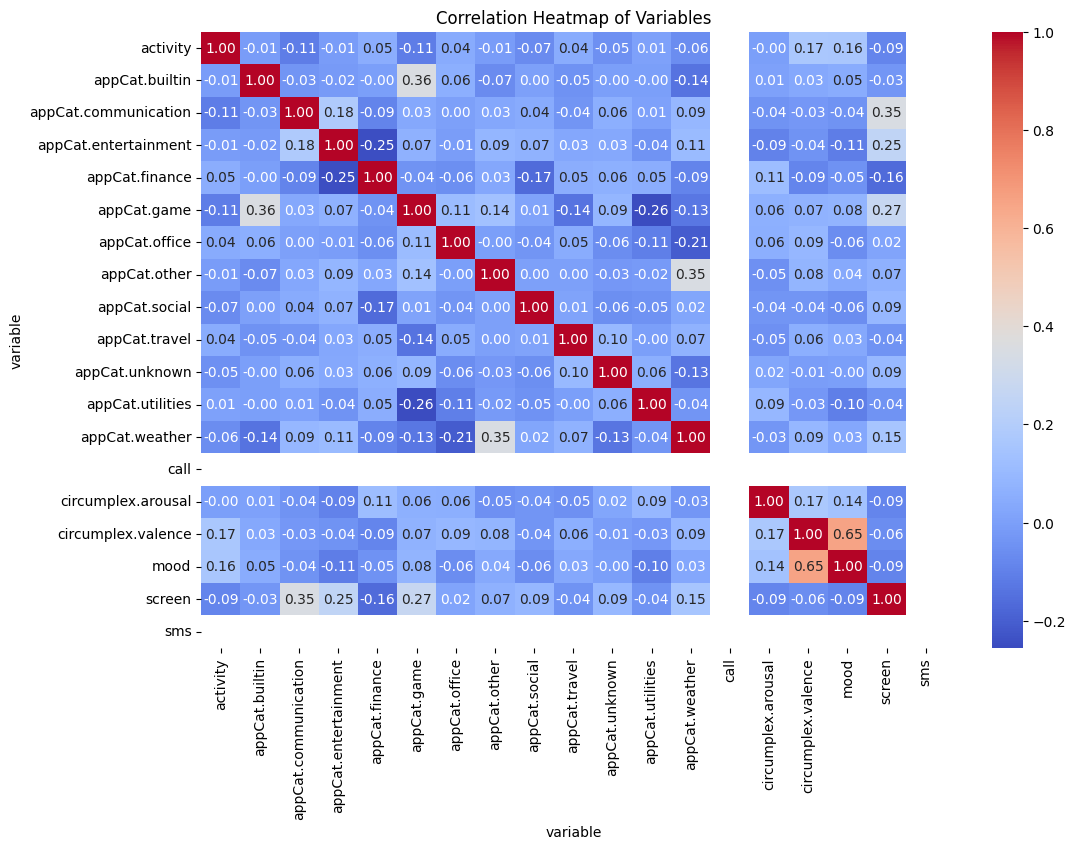

In [7]:
# Correlation heatmap of variables
data = df.groupby(['id','variable',df['time'].dt.date])['value'].mean()
data = data.reset_index()
data['value'] = data['value'].astype(float)
data['time'] = data['time'].astype("string")
data.loc[data['variable'] == 'mood', 'value'] = np.round(data.loc[data['variable'] == 'mood', 'value'])

pivot_table = data.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='mean')
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Variables')
plt.show()

Correlation heatmap to visualize the correlation between different variables in the dataset. The heatmap provides a color-coded representation of the correlation values, with warmer colors indicating stronger positive correlations and cooler colors indicating stronger negative correlations. (Call is not visible as its boolean and only recorded when a call takes place so it always has a value of 1).

Arousal, and especially valence seem to be highly positively corellated with mood for example, while using finance apps seems to highly negatively correlate with screen time, which could be useful features to consider when making new predictions.

#### Activity & mood relationship

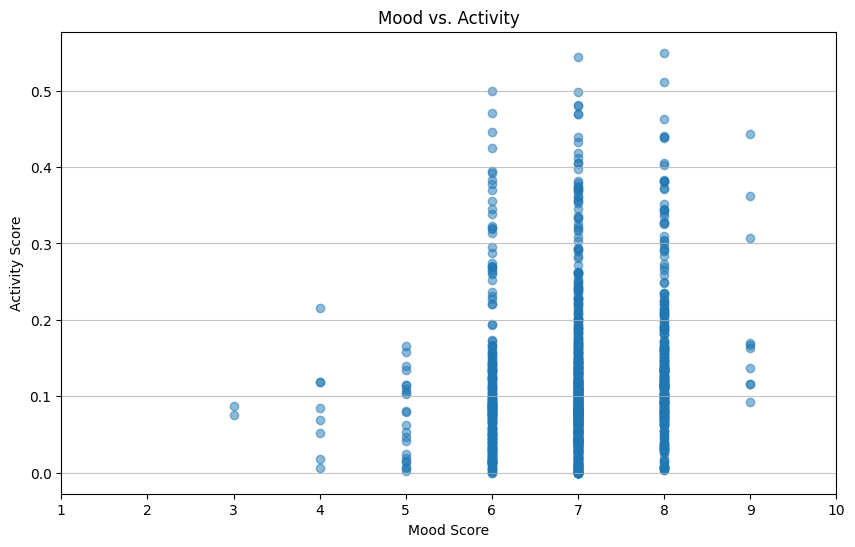

In [8]:
# Activity and Mood Relationship
activity_data = data[data['variable'] == 'activity']
mood_data = data[data['variable'] == 'mood']

# Merging on ID and Time for direct comparison
activity_mood_merged = pd.merge(activity_data, mood_data, on=['id', 'time'], suffixes=('_activity', '_mood'))

plt.figure(figsize=(10, 6))
plt.scatter(activity_mood_merged['value_mood'], activity_mood_merged['value_activity'], alpha=0.5)
plt.title('Mood vs. Activity')
plt.xlabel('Mood Score')
plt.ylabel('Activity Score')
plt.xticks(range(1, 11))
plt.grid(axis='y', alpha=0.75)
plt.show()

Plot showing co-occurence of mood with activiy scores. If the mood is in the common range of 7±1 we see participants record a wide range of activity scores, while if the mood is low, there is no high activity. 

### 1.2 - Data Cleaning

#### Adapting datatypes

Because call and sms are boolean (only present if true) we convert them to boolean values.

In [9]:
# Convert 'call' and 'sms' data to boolean
for variable in ['call', 'sms']:
    df.loc[df['variable'] == variable, 'value'] = df[df['variable'] == variable]['value'].fillna(0).astype(bool)

#### Removing incorrect values

Because all `appCat.*` variables and `screen` should denote a time duration, they cannot be negative. Thus, any records with negative duration must be incorrect and removed. We see this is the case for example when looking at the variables properties table under section 1.1, where the min value for `appCat.builtin` is highly negative.

In [10]:
# List of variables denoting time durations
time_variables = [var for var in df['variable'].unique() if 'appCat.' in var or var == 'screen']

# Remove records with negative durations for time variables
print("Removed records due to negative values:")
initial_count = df.shape[0]
for var in time_variables:
    before_count = df[df['variable'] == var].shape[0]
    df = df[~((df['variable'] == var) & (df['value'] < 0))]
    after_count = df[df['variable'] == var].shape[0]
    print(f"{before_count - after_count} from {var}")

total_removed = initial_count - df.shape[0]
print(f"Total records removed: {total_removed}")

Removed records due to negative values:
0 from screen
3 from appCat.builtin
0 from appCat.communication
1 from appCat.entertainment
0 from appCat.finance
0 from appCat.game
0 from appCat.office
0 from appCat.other
0 from appCat.social
0 from appCat.travel
0 from appCat.unknown
0 from appCat.utilities
0 from appCat.weather
Total records removed: 4


#### Removing extreme values

For numeric variables that are not self-reported by the participants (so not mood, arousal, valence & activity, and also not call or SMS) we remove values that lie outside of the z-score threshold of ±3. Points that are more than 3 standard deviations away from the mean are considered outliers and should thus not be considered in our dataset. This should offer a more robust removal of outliers than other statistical methods like Interquartile Range, because it can better handle data distributions with heavier tails, like some of our variable values are as can be seen by the histograms for section 1.1.

In [11]:
# Outlier removal using the Interquartile Range (IQR) method
def remove_iqr_outliers(df, variable):
    # Filter the dataset for a specific variable
    iqr_range = 1.5

    filter_df = df[df['variable'] == variable]
    Q1 = filter_df['value'].quantile(0.25)
    Q3 = filter_df['value'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - iqr_range * IQR
    upper_bound = Q3 + iqr_range * IQR

    # Filtering out outliers
    before_removal = filter_df.shape[0]
    filtered_df = filter_df[(filter_df['value'] >= lower_bound) & (filter_df['value'] <= upper_bound)]
    after_removal = filtered_df.shape[0]

    print(f'Removed {before_removal - after_removal} outliers from {variable}')
    return df[(df['variable'] != variable) | ((df['value'] >= lower_bound) & (df['value'] <= upper_bound))]

# Variables for which we remove outliers
exclude_vars = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'call', 'sms']
outlier_vars = [var for var in df['variable'].unique() if var not in exclude_vars]

print('Removed outliers using Z-score method:')
for var in outlier_vars:
    df = remove_iqr_outliers(df, var)

Removed outliers using Z-score method:
Removed 10055 outliers from screen
Removed 10150 outliers from appCat.builtin
Removed 6401 outliers from appCat.communication
Removed 4517 outliers from appCat.entertainment
Removed 118 outliers from appCat.finance
Removed 85 outliers from appCat.game
Removed 848 outliers from appCat.office
Removed 1000 outliers from appCat.other
Removed 1838 outliers from appCat.social
Removed 181 outliers from appCat.travel
Removed 80 outliers from appCat.unknown
Removed 182 outliers from appCat.utilities
Removed 10 outliers from appCat.weather


In [12]:
#*** OLD ***
# # Variables for which we remove outliers
# exclude_vars = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'call', 'sms']
# outlier_vars = [var for var in df['variable'].unique() if var not in exclude_vars]

# # Removing outliers using Z-score method
# print("Removed outliers using Z-score method:")
# initial_count = df.shape[0]
# for var in outlier_vars:
#     # Calculate Z-scores for the variable
#     var_data = df[df['variable'] == var]['value']
#     z_scores = np.abs((var_data - var_data.mean()) / var_data.std())
    
#     # Filter out data points where the absolute Z-score is greater than 3
#     before_count = df[df['variable'] == var].shape[0]
#     df = df[~((df['variable'] == var) & (df.index.isin(z_scores[z_scores > 3].index)))]
#     after_count = df[df['variable'] == var].shape[0]
#     print(f'{before_count - after_count} from {var}')

# total_removed = initial_count - df.shape[0]
# print(f'Total records removed: {total_removed}')

#### Distribution of variable values post cleaning

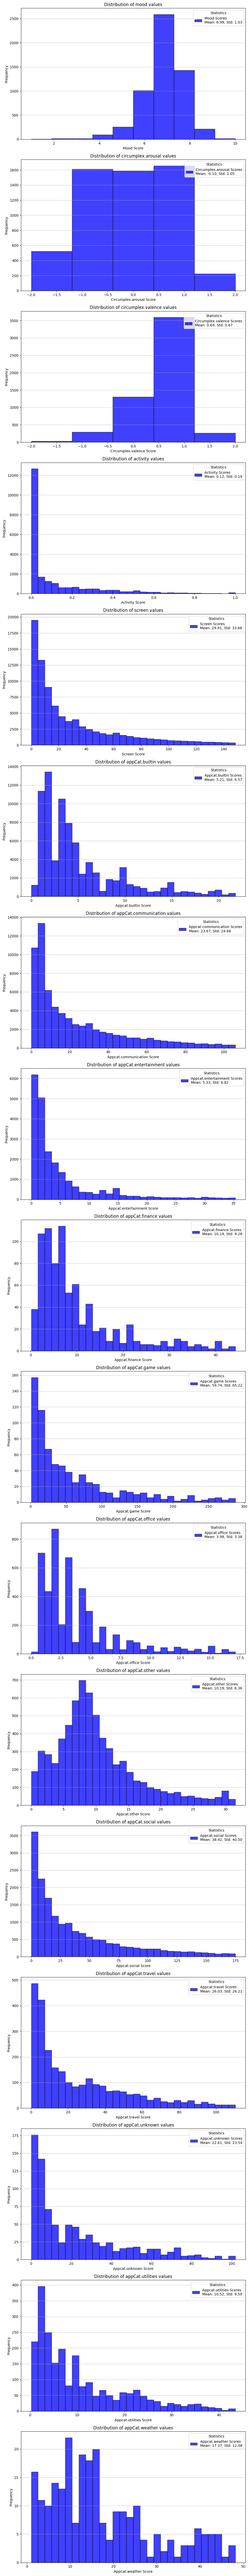

In [13]:
variables = [var for var in df['variable'].unique() if var not in ['sms', 'call']]
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 6 * len(variables)))

for ax, var in zip(axes.flatten(), variables):
    var_data = df[df['variable'] == var]['value'].dropna()
    mean = var_data.mean()
    std = var_data.std()
    # Adjust bins for better visualization based on data range and characteristics
    bins = min(30, int(var_data.nunique()))  # Use a minimum of 30 bins or less if fewer unique values

    ax.hist(var_data, bins=bins, alpha=0.75, color='blue', edgecolor='black', label=f'{var} Scores')
    ax.set_title(f'Distribution of {var} values')
    ax.set_xlabel(f'{var.capitalize()} Score')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.75)
    legend_label = f"Mean: {mean:.2f}, Std: {std:.2f}"
    ax.legend([f"{var.capitalize()} Scores\n{legend_label}"], loc='upper right', title='Statistics', frameon=True)

plt.tight_layout()
plt.show()

We can see that the values for the different variables are now much more normally distributed, as can be expected for time duration readings for our specific data. When comparing the histograms with those created before the cleaning, we no longer have few very high frequency bins and small bins extremely far away.

#### Imputing missing values (still todo, Ryan)

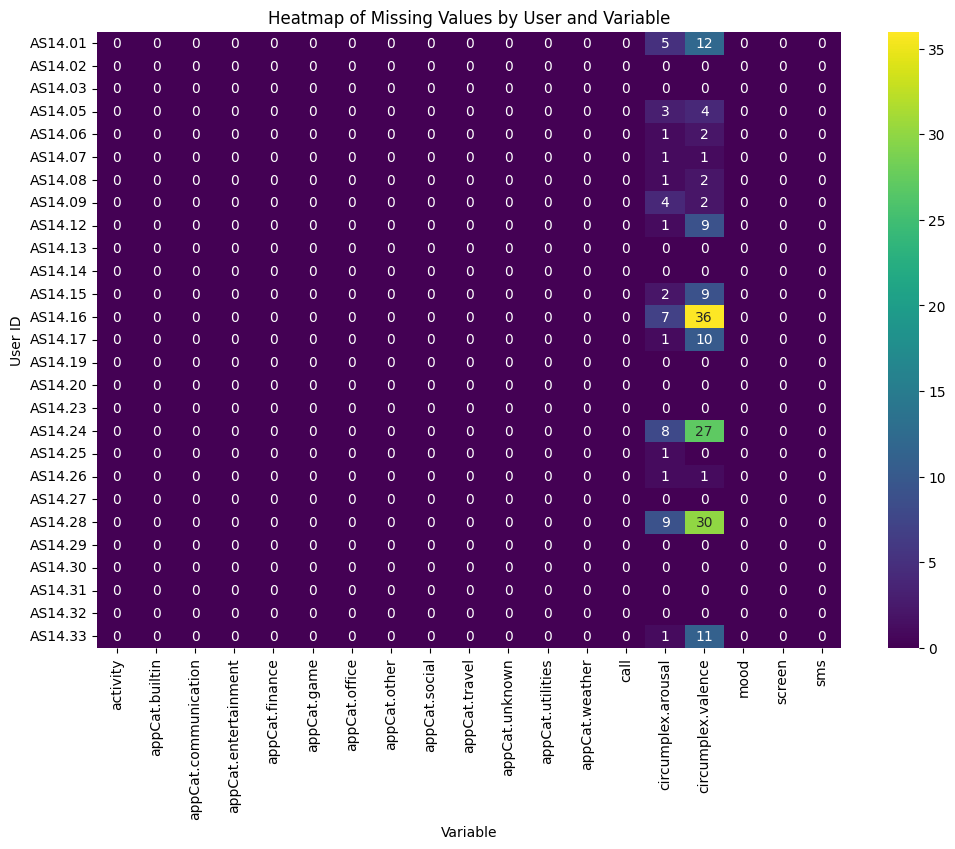

In [14]:
# Group the data by 'id' and 'variable' and count NaN values for each grouping
nan_counts = df.groupby(['id', 'variable']).apply(lambda x: x['value'].isnull().sum()).reset_index(name='Missing Values')

# Pivot the results to get a better visual representation: users on rows, variables on columns
nan_pivot = nan_counts.pivot(index='id', columns='variable', values='Missing Values').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(nan_pivot, annot=True, fmt="g", cmap='viridis')
plt.title('Heatmap of Missing Values by User and Variable')
plt.xlabel('Variable')
plt.ylabel('User ID')
plt.show()

Based on this heatmap, we see that NaN values only occur for the circumplex variables, most notably for valence. Furthermore, only a small subset of the participants have missing values.

In [15]:
# Code to impute missing values
# ! GPT-4 code:
import pandas as pd

# Assuming 'df' is your DataFrame and 'time' is the index if not, set it accordingly
# df.set_index('time', inplace=True)

# Linear Interpolation
df_linear = df.copy()
for var in df['variable'].unique():
    if 'time' not in df.index.names:
        df_linear.loc[df_linear['variable'] == var, 'value'] = df_linear[df_linear['variable'] == var]['value'].interpolate(method='linear')

# Simple Exponential Smoothing
df_ses = df.copy()
for var in df['variable'].unique():
    if 'time' not in df.index.names:
        df_ses.loc[df_ses['variable'] == var, 'value'] = df_ses[df_ses['variable'] == var]['value'].fillna(method='pad').ewm(alpha=0.3).mean()

# Comparison of the impact
print("Linear Interpolation Sample:")
print(df_linear[df_linear['variable'] == 'mood']['value'].head(10))

print("Exponential Smoothing Sample:")
print(df_ses[df_ses['variable'] == 'mood']['value'].head(10))

Linear Interpolation Sample:
1     6.0
2     6.0
3     6.0
4     7.0
5     6.0
6     6.0
7     7.0
8     6.0
9     6.0
10    7.0
Name: value, dtype: object
Exponential Smoothing Sample:
1          6.0
2          6.0
3          6.0
4     6.394789
5     6.252425
6       6.1666
7     6.439058
8     6.299283
9     6.205723
10    6.450932
Name: value, dtype: object


## Start on basic predicition

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# NOTE: this is still little basic format for the model, will maybe have to run on Google colab?


x = df # input features
y = df[df['variable'] == 'mood'] # target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Transform data 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# Define the CNN model, three layers
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_test_reshaped, y_test))

loss = model.evaluate(x_test_reshaped, y_test)
print(f'Test loss: {loss}')

predictions = model.predict(x_test_reshaped)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
entertainment_vars =  ['appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.social']
util_vars =  ['appCat.builtin', 'appCat.communication', 'appCat.travel', 'appCat.utilities', 'appCat.weather']
other_vars =  ['appCat.other', 'appCat.office', 'appCat.finance']

In [ ]:
for variable in entertainment_vars:
    df.loc[df['variable'] == variable, 'variable'] = 'entertainment'
for variable in util_vars:
    df.loc[df['variable'] == variable, 'variable'] = 'util'
for variable in other_vars:
    df.loc[df['variable'] == variable, 'variable'] = 'other'

In [ ]:
pd.unique(df['variable'])

In [ ]:
values = df.groupby(['id','variable',df['time'].dt.date])['value'].mean()
values = values.reset_index()
values['value'] = values['value'].astype(float)
values['time'] = values['time'].astype("string")
values.loc[values['variable'] == 'mood', 'value'] = np.round(values.loc[values['variable'] == 'mood', 'value'])
values

In [ ]:
columns_new = ['id','day', 'mood', 'circumplex.arousal','circumplex.valence', 'activity', 'screen', 'call', 'sms','entertainment', 'util', 'other']
feature_engineered_df = pd.DataFrame(columns = columns_new)

In [ ]:
for user in pd.unique(values['id']):
    for day in pd.unique(values['time']):
        new_values = values[(values['id'] == user)&(values['time'] == day)]
        if(new_values.empty == False):
            new_row = []
            for column  in feature_engineered_df:
                if column in pd.unique(new_values['variable']):
                    new_row.append(list(new_values.loc[new_values['variable'] == column,'value'])[0])
                else:
                    new_row.append(-10)
            new_row[0] = user
            new_row[1] = day
            feature_engineered_df.loc[len(feature_engineered_df.index)] = new_row
feature_engineered_df['day'] = pd.to_datetime(feature_engineered_df['day'])
feature_engineered_df

In [ ]:
final_df = pd.DataFrame()
drop_indexes = []
feature_engineered_grouped = feature_engineered_df.groupby(['id'])
for group in feature_engineered_grouped.groups.keys():
    group_df = feature_engineered_grouped.get_group(group)
    
    for i in range(len(group_df)):
        day = group_df.loc[group_df.index[i], 'day']
        next_day = day +  pd.DateOffset(1)
        if(len(group_df[group_df['day'] == next_day])> 0):
            next_day_mood = group_df.loc[group_df['day'] == next_day,'mood']
            if(next_day_mood.item() == -10):
                drop_indexes.append(group_df.index[i])
                continue
            group_df.loc[group_df.index[i], 'next_day_mood'] = next_day_mood.item()
        else:
            drop_indexes.append(group_df.index[i])
        
    final_df = pd.concat([final_df,group_df])

final_df = final_df.drop(drop_indexes)

In [ ]:
for column in final_df:
    print(f'{column}:{1-(len(final_df[final_df[column] == -10])/len(final_df))}')

In [ ]:
param_grid = { 
    'n_estimators': [350, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

final_df = final_df.dropna()
X = final_df.filter(items=['mood','circumplex.arousal', 'circumplex.valence', 'activity', 'screen','entertainment','util','other','next_day_mood'])
for column in X:
    print(f'{column}:{1-(len(X[X[column] == -10])/len(X))}')
labels = X['next_day_mood']
X = X.drop(['next_day_mood'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split( X,labels, test_size=0.2, random_state=0)

clf = RandomForestClassifier(max_depth= 10,random_state=0)
transformer = ColumnTransformer( [("numerical", StandardScaler(), ['circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'entertainment', 'util', 'other']),("categorical", OneHotEncoder(),['mood'])])
pipe = Pipeline(steps=[("transformer", transformer), ("RandomForest", clf)])
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_clf.fit(X_train, y_train)
y_pred = CV_clf.predict(X_train)
print(f'Train_accuracy: {accuracy_score(y_train,y_pred)}')
y_pred = CV_clf.predict(X_test)
print(f'Test_accuracy: {accuracy_score(y_test,y_pred)}')

In [ ]:
print(CV_clf.best_params_)
print(sum(labels == 7)/len(labels))
plt.hist(labels)

# Old code (I think Lieve's :))

In [ ]:
# clean data by dropping NA values

cleaned_data = df[df['value'] != 'NA'].dropna()

# TODO: remove outliers for each variable and write in report why/how

print(cleaned_data)

In [ ]:
# Histogram of mood 
plt.figure(figsize=(8, 6))
plt.hist(cleaned_data[cleaned_data['variable'] == 'mood']['value'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Mood')
plt.xlabel('Mood')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Boxplot of arousal 
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data[cleaned_data['variable'] == 'circumplex.arousal']['value'], vert=True)
plt.title('Boxplot of arousal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of valence 
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data[cleaned_data['variable'] == 'circumplex.valence']['value'], vert=True)
plt.title('Boxplot of valence')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series plot of mood
# TODO: fix errors and readability of plot
grouped_data = cleaned_data.groupby('id')

# Plot for each 'id'
plt.figure(figsize=(30, 6))
for name, group in grouped_data:
    plt.plot(group.loc[cleaned_data['variable'] == 'mood','time'], group.loc[cleaned_data['variable'] == 'mood','value'], label=name, linewidth=1)
    # plt.plot(group['time'], group['value'], label=name, linewidth=1)
    # plt.plot(cleaned_data[cleaned_data['variable'] == 'mood']['time'], cleaned_data[cleaned_data['variable'] == 'mood']['value'], linewidth=1)

plt.title('Time Series Plot of Mood')
plt.xlabel('Time')
plt.ylabel('Mood')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Time series of activity
# TODO: fix errors and readability of plot
grouped_data = cleaned_data.groupby('id')

# Plot for each 'id'
plt.figure(figsize=(30, 6))
for name, group in grouped_data:
    plt.plot(group.loc[cleaned_data['variable'] == 'activity','time'], group.loc[cleaned_data['variable'] == 'activity','value'], label=name, linewidth=1)
    # plt.plot(group['time'], group['value'], label=name, linewidth=1)
    # plt.plot(cleaned_data[cleaned_data['variable'] == 'mood']['time'], cleaned_data[cleaned_data['variable'] == 'mood']['value'], linewidth=1)

plt.title('Time Series Plot of Activity')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time series of activity AND mood

avg_activity = cleaned_data[cleaned_data['variable'] == 'activity'].groupby(cleaned_data['time'].dt.date)['value'].mean()
avg_mood = cleaned_data[cleaned_data['variable'] == 'mood'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Activity', color='tab:red')
ax1.plot(avg_activity.index, avg_activity.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

# Time series of screen AND mood
avg_screen = cleaned_data[cleaned_data['variable'] == 'screen'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('screen', color='tab:red')
ax1.plot(avg_screen.index, avg_screen.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

# Time series of utilities app and mood
avg_ut = cleaned_data[cleaned_data['variable'] == 'appCat.utilities'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Utilities', color='tab:red')
ax1.plot(avg_ut.index, avg_ut.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

In [ ]:
# convert to pandas dataframe
df = pd.DataFrame(cleaned_data, columns=["", "id", "time", "variable", "value"])

groups = df.groupby('variable')['value']

# TODO: fix statistical test so we can remove variables which are not significant

# Perform statistical tests for each variable
for var, group in groups:
    if var != 'mood':
        if len(group.unique()) > 2: 
            f_statistic, p_value = stats.f_oneway(*[group for name, group in groups])
            if p_value < 0.05:
                print(f"Variable '{var}' is significant (p-value: {p_value:.4f}, f stat: {f_statistic})")
            else:
                print(f"Variable '{var}' is not significant (p-value: {p_value:.4f}, f stat: {f_statistic})")